# Support Vector Machine (SVM)
## Linear SVM & Kernel SVM (with RBF Kernel)

In [1]:
# Data Loading and Preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

In [10]:
# Baseline without CV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.svm import SVC

# Linear SVM
# Primary Type
svm_linear_primary = SVC(kernel='linear', random_state=42)
svm_linear_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = svm_linear_primary.predict(X_test_scaled)
print("Linear SVM - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
svm_linear_both = MultiOutputClassifier(SVC(kernel='linear', random_state=42))
svm_linear_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = svm_linear_both.predict(X_test_scaled)
print("Linear SVM - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
svm_linear_generation = SVC(kernel='linear', random_state=42)
svm_linear_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = svm_linear_generation.predict(X_test_scaled)
print("Linear SVM - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

# RBF SVM
# Primary Type
svm_rbf_primary = SVC(kernel='rbf', random_state=42)
svm_rbf_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = svm_rbf_primary.predict(X_test_scaled)
print("RBF SVM - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
svm_rbf_both = MultiOutputClassifier(SVC(kernel='rbf', random_state=42))
svm_rbf_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = svm_rbf_both.predict(X_test_scaled)
print("RBF SVM - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
svm_rbf_generation = SVC(kernel='rbf', random_state=42)
svm_rbf_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = svm_rbf_generation.predict(X_test_scaled)
print("RBF SVM - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))


Linear SVM - Primary Type Accuracy: 0.18536585365853658
Linear SVM - Both Types Hamming Loss: 0.08130081300813008
Linear SVM - Generation Accuracy: 0.21951219512195122
RBF SVM - Primary Type Accuracy: 0.23414634146341465
RBF SVM - Both Types Hamming Loss: 0.08130081300813008
RBF SVM - Generation Accuracy: 0.2048780487804878


In [2]:
# Model Implementation
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

# Linear SVM
svm_linear_primary = SVC(kernel='linear', random_state=42)
svm_linear_both = MultiOutputClassifier(SVC(kernel='linear', random_state=42))
svm_linear_generation = SVC(kernel='linear', random_state=42)

# Kernel SVM (RBF)
svm_rbf_primary = SVC(kernel='rbf', random_state=42)
svm_rbf_both = MultiOutputClassifier(SVC(kernel='rbf', random_state=42))
svm_rbf_generation = SVC(kernel='rbf', random_state=42)

In [ ]:
# Training and Evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, hamming_loss, accuracy_score, f1_score, jaccard_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test, param_grid, is_multilabel=False):
    # Before tuning
    if is_multilabel:
        scores_before = cross_val_score(model, X_train, y_train, cv=5, 
                                        scoring=make_scorer(hamming_loss, greater_is_better=False))
        print(f"Before tuning - Mean CV Hamming Loss: {-scores_before.mean():.3f} (+/- {scores_before.std() * 2:.3f})")
    else:
        scores_before = cross_val_score(model, X_train, y_train, cv=5)
        print(f"Before tuning - Mean CV score: {scores_before.mean():.3f} (+/- {scores_before.std() * 2:.3f})")

    # After tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, 
                               scoring='neg_hamming_loss' if is_multilabel else 'accuracy')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print(f"After tuning - Best cross-validation score: {-grid_search.best_score_:.3f}" if is_multilabel 
          else f"After tuning - Best cross-validation score: {grid_search.best_score_:.3f}")

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    if is_multilabel:
        test_hamming_loss = hamming_loss(y_test, y_pred)
        print(f"Test set Hamming Loss: {test_hamming_loss:.3f}")
        
        exact_matches = np.all(y_pred == y_test, axis=1)
        exact_match_ratio = np.mean(exact_matches)
        print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
        
        jaccard_score_value = jaccard_score(y_test, y_pred, average='samples')
        print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
        
        f1_score_value = f1_score(y_test, y_pred, average='samples')
        print(f"F1 Score: {f1_score_value:.3f}")
    else:
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"Test set accuracy: {test_accuracy:.3f}")

    return grid_search.best_estimator_

In [4]:
# Primary Type Prediction
print("Linear SVM - Primary Type Prediction:")
param_grid_linear = {'C': [0.1, 1, 10, 100]}
best_linear_primary = train_and_evaluate(svm_linear_primary, X_train_scaled, y_train_primary, 
                                         X_test_scaled, y_test_primary, param_grid_linear)

print("\nKernel SVM (RBF) - Primary Type Prediction:")
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 1]}
best_rbf_primary = train_and_evaluate(svm_rbf_primary, X_train_scaled, y_train_primary, 
                                      X_test_scaled, y_test_primary, param_grid_rbf)

Linear SVM - Primary Type Prediction:
Before tuning - Mean CV score: 0.220 (+/- 0.057)
Best parameters: {'C': 1}
After tuning - Best cross-validation score: 0.220
Test set accuracy: 0.185

Kernel SVM (RBF) - Primary Type Prediction:
Before tuning - Mean CV score: 0.221 (+/- 0.039)
Best parameters: {'C': 10, 'gamma': 0.1}
After tuning - Best cross-validation score: 0.246
Test set accuracy: 0.229


In [ ]:
# Define a negative Hamming loss function
# This is needed because GridSearchCV tries to maximize the score,
# but we want to minimize the Hamming loss, and it is not implemented in GridSearchCV.
# By negating the Hamming loss, we turn the minimization problem into a maximization problem.
def neg_hamming_loss(y_true, y_pred):
    return -hamming_loss(y_true, y_pred)

# Create a scorer using the negative Hamming loss function
# This allows us to use Hamming loss as a scoring metric in GridSearchCV
hamming_scorer = make_scorer(neg_hamming_loss)

# Both Types Prediction for Linear SVM
print("\nLinear SVM - Both Types Prediction:")

# Before tuning
scores_both_before = cross_val_score(svm_linear_both, X_train_scaled, y_train_both_bin, cv=5, 
                                     scoring=hamming_scorer)
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# After tuning
param_grid_linear_both = {'estimator__C': [0.1, 1, 10, 100]}
grid_search_both = GridSearchCV(svm_linear_both, param_grid_linear_both, cv=5, scoring=hamming_scorer)
grid_search_both.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

# Evaluate on test set
y_pred_both = grid_search_both.predict(X_test_scaled)
test_hamming_loss = hamming_loss(y_test_both_bin, y_pred_both)
print(f"Test set Hamming Loss: {test_hamming_loss:.3f}")

# Calculate exact match ratio
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.3f}")

# Both Types Prediction for Kernel SVM (RBF)
print("\nKernel SVM (RBF) - Both Types Prediction:")

# Before tuning
scores_both_before = cross_val_score(svm_rbf_both, X_train_scaled, y_train_both_bin, cv=5, 
                                     scoring=hamming_scorer)
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# After tuning
param_grid_rbf_both = {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': ['scale', 'auto', 0.1, 1]}
grid_search_both_rbf = GridSearchCV(svm_rbf_both, param_grid_rbf_both, cv=5, scoring=hamming_scorer)
grid_search_both_rbf.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both_rbf.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both_rbf.best_score_:.3f}")

# Evaluate on test set
y_pred_both_rbf = grid_search_both_rbf.predict(X_test_scaled)
test_hamming_loss_rbf = hamming_loss(y_test_both_bin, y_pred_both_rbf)
print(f"Test set Hamming Loss: {test_hamming_loss_rbf:.3f}")

# Calculate exact match ratio
exact_matches_rbf = np.all(y_pred_both_rbf == y_test_both_bin, axis=1)
exact_match_ratio_rbf = np.mean(exact_matches_rbf)
print(f"Exact Match Ratio: {exact_match_ratio_rbf:.3f}")



Linear SVM - Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.085 (+/- 0.002)
Best parameters: {'estimator__C': 0.1}
After tuning - Best cross-validation Hamming Loss: 0.085
Test set Hamming Loss: 0.081
Exact Match Ratio: 0.000

Kernel SVM (RBF) - Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.085 (+/- 0.002)
Best parameters: {'estimator__C': 0.1, 'estimator__gamma': 'scale'}
After tuning - Best cross-validation Hamming Loss: 0.085
Test set Hamming Loss: 0.081
Exact Match Ratio: 0.000


In [7]:
# Generation Prediction
print("\nLinear SVM - Generation Prediction:")
best_linear_generation = train_and_evaluate(svm_linear_generation, X_train_scaled, y_train_generation, 
                                            X_test_scaled, y_test_generation, param_grid_linear)

print("\nKernel SVM (RBF) - Generation Prediction:")
best_rbf_generation = train_and_evaluate(svm_rbf_generation, X_train_scaled, y_train_generation, 
                                         X_test_scaled, y_test_generation, param_grid_rbf)


Linear SVM - Generation Prediction:
Before tuning - Mean CV score: 0.166 (+/- 0.066)
Best parameters: {'C': 10}
After tuning - Best cross-validation score: 0.168
Test set accuracy: 0.229

Kernel SVM (RBF) - Generation Prediction:
Before tuning - Mean CV score: 0.188 (+/- 0.074)
Best parameters: {'C': 10, 'gamma': 'auto'}
After tuning - Best cross-validation score: 0.221
Test set accuracy: 0.195


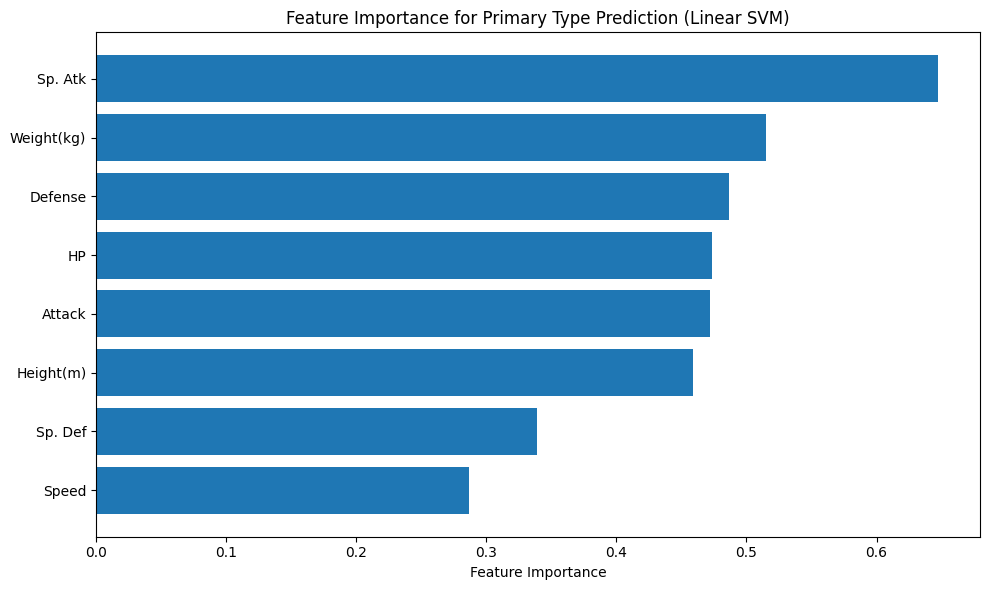

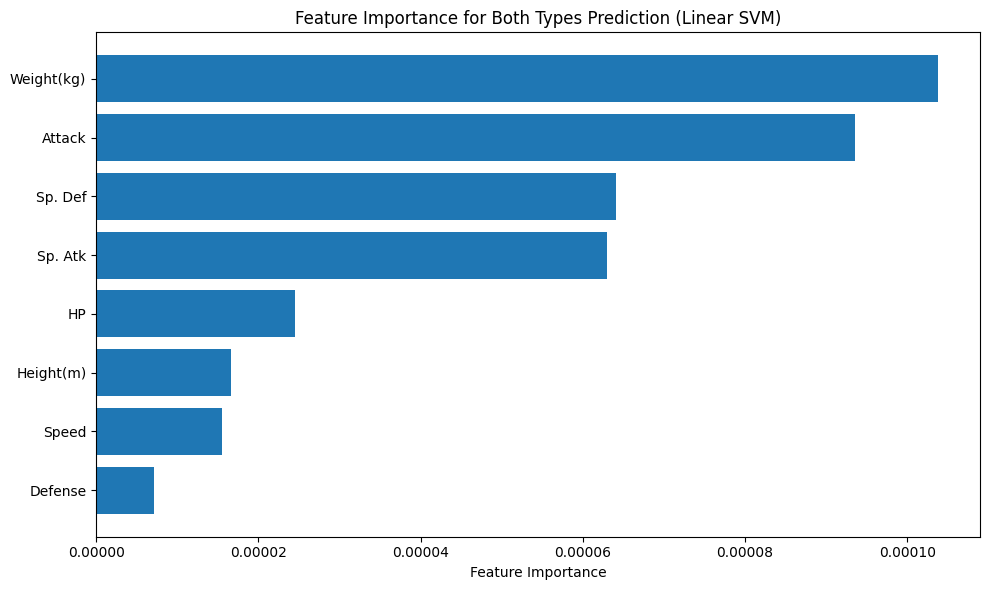

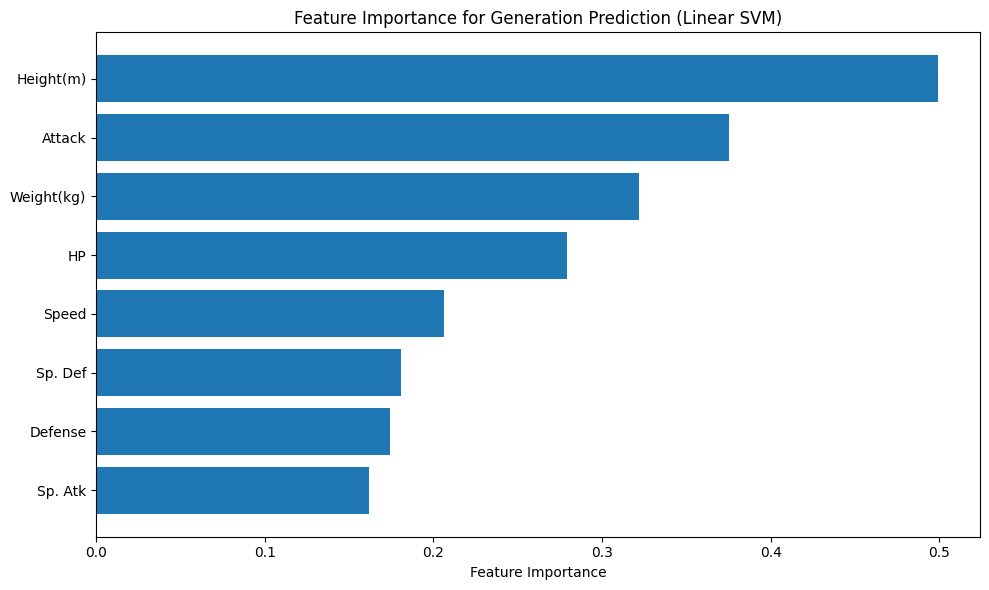

In [9]:
# Feature Importance (for Linear SVM only)
import matplotlib.pyplot as plt

def plot_feature_importance(importance, title):
    sorted_idx = importance.argsort()
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10, 6))
    plt.barh(pos, importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Primary Type Feature Importance 
primary_importance = np.abs(best_linear_primary.coef_).mean(axis=0)
plot_feature_importance(primary_importance, 'Feature Importance for Primary Type Prediction (Linear SVM)')

# Both Types Feature Importance (Linear SVM)
both_importance = np.abs(grid_search_both.best_estimator_.estimators_[0].coef_).mean(axis=0)
plot_feature_importance(both_importance, 'Feature Importance for Both Types Prediction (Linear SVM)')

# Generation Feature Importance 
gen_importance = np.abs(best_linear_generation.coef_).mean(axis=0)
plot_feature_importance(gen_importance, 'Feature Importance for Generation Prediction (Linear SVM)')

## All features

In [1]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('engineered_csv/train_combined_features.csv')
test_df = pd.read_csv('engineered_csv/test_combined_features.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'RGB_Min', 
                  'LBP_Mean', 'LBP_Std', 'LBP_Max', 'LBP_Min',
                  'CNN_Mean', 'CNN_Std', 'CNN_Max', 'CNN_Min']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

all_features = original_features + engineered_features + image_features

# Check if all features are present in the dataframes
missing_features = [f for f in all_features if f not in train_df.columns or f not in test_df.columns]
if missing_features:
    print("Warning: The following features are missing:", missing_features)
    all_features = [f for f in all_features if f not in missing_features]

X_train = train_df[all_features]
X_test = test_df[all_features]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("\nX_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

Train dataset shape: (820, 47)
Test dataset shape: (205, 47)
X_train shape: (820, 39)
X_test shape: (205, 39)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 39)
X_test_scaled shape: (205, 39)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 

In [3]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
from sklearn.svm import SVC
import numpy as np

# Linear SVM
# Primary Type
svm_linear_primary = SVC(kernel='linear', random_state=42, probability=True)
svm_linear_primary.fit(X_train_final, y_train_primary)
y_pred_primary = svm_linear_primary.predict(X_test_final)
print("Linear SVM - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
svm_linear_both = MultiOutputClassifier(SVC(kernel='linear', random_state=42, probability=True))
svm_linear_both.fit(X_train_final, y_train_both_bin)
y_pred_both = svm_linear_both.predict(X_test_final)
y_pred_both_probas = svm_linear_both.predict_proba(X_test_final)

print("Linear SVM - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics for Both Types
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Generation
svm_linear_generation = SVC(kernel='linear', random_state=42)
svm_linear_generation.fit(X_train_final, y_train_generation)
y_pred_generation = svm_linear_generation.predict(X_test_final)
print("Linear SVM - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

# RBF SVM
# Primary Type
svm_rbf_primary = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf_primary.fit(X_train_final, y_train_primary)
y_pred_primary = svm_rbf_primary.predict(X_test_final)
print("RBF SVM - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
svm_rbf_both = MultiOutputClassifier(SVC(kernel='rbf', random_state=42, probability=True))
svm_rbf_both.fit(X_train_final, y_train_both_bin)
y_pred_both = svm_rbf_both.predict(X_test_final)
y_pred_both_probas = svm_rbf_both.predict_proba(X_test_final)

print("RBF SVM - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics for Both Types
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Generation
svm_rbf_generation = SVC(kernel='rbf', random_state=42)
svm_rbf_generation.fit(X_train_final, y_train_generation)
y_pred_generation = svm_rbf_generation.predict(X_test_final)
print("RBF SVM - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Linear SVM - Primary Type Accuracy: 0.2097560975609756
Linear SVM - Both Types Hamming Loss: 0.08130081300813008
Exact Match Ratio: 0.015
Jaccard Similarity Score: 0.015
F1 Score: 0.015
Linear SVM - Generation Accuracy: 0.4195121951219512
RBF SVM - Primary Type Accuracy: 0.21951219512195122
RBF SVM - Both Types Hamming Loss: 0.08130081300813008
Exact Match Ratio: 0.000
Jaccard Similarity Score: 0.000
F1 Score: 0.000
RBF SVM - Generation Accuracy: 0.32195121951219513
